In [1]:
from langchain_groq import ChatGroq 
from dotenv import load_dotenv
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, START , END
from typing import TypedDict, Literal
from pydantic import BaseModel , Field
import os


In [2]:
load_dotenv()

True

In [3]:
model = ChatGroq(model_name = 'openai/gpt-oss-20b', api_key = os.getenv("GROQ_API_KEY"))

In [4]:
class SentimentSchema(BaseModel):
    sentiment : Literal['positive','negative'] = Field(description = 'sentiment of the review')

In [17]:
class DiagnosisSchema(BaseModel):
    issue_type : Literal['UX','Performance', 'Bug','Suppport','Other'] = Field(description = "The category of issue mentioned in the review")
    tone : Literal['angry','frustrated','disappointed','calm'] = Field(description="The emotional tone expressed by the used")
    urgency : Literal['low','medium','high']                                                              = Field(description="How urgent or critical the issue appears to be")


In [19]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model1 = model.with_structured_output(DiagnosisSchema)

In [6]:
prompt ='what is the sentiment of the following review - The software is too goog'
structured_model.invoke(prompt).sentiment

'negative'

In [12]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [13]:
def find_sentiment(state: ReviewState):

    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = structured_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}

     

In [37]:
def check_sentiment(state : ReviewState) -> Literal['positive_response','run_diagnosis'] :
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else :
        return 'run_diagnosis'
        

def positive_response(state : ReviewState):
    prompt = f""" Write a warm thank-you message in response to this review:
    \n\n "{state['review']}"\n
    Also , Kindly ask the user to leave feedback on our website."""
    response = model.invoke(prompt).content
    return {'response':response}

def run_diagnosis(state : ReviewState):

    prompt = f"""Diagnosis this negative review :\n\n"{state['review']}\n"Return issue_type, tone, and urgency"""
    response = structured_model1.invoke(prompt)
    return {'diagnosis':response.model_dump()}

def negative_response(state : ReviewState):
    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistant.
                 The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
                 Write an empathetic, helpful resolution message."""  
    response = model.invoke(prompt).content
    return {'response':response}

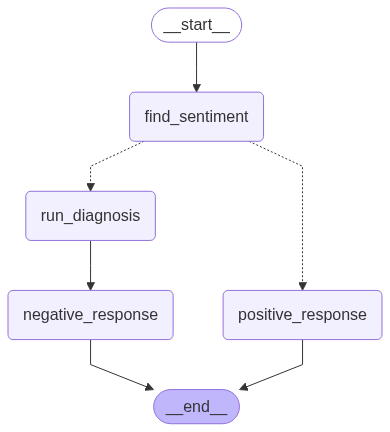

In [38]:
graph = StateGraph(ReviewState)

# add nodes 
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)



# add a edge
graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_sentiment)
graph.add_edge('positive_response',END)
graph.add_edge('run_diagnosis','negative_response')
graph.add_edge('negative_response', END)

graph.compile()

In [45]:
workflow = graph.compile()

In [46]:
initial_state = {
    'review':'This software is too bad'
}
response = workflow.invoke(initial_state)

print(response)

{'review': 'This software is too bad', 'sentiment': 'negative', 'diagnosis': {'issue_type': 'Other', 'tone': 'disappointed', 'urgency': 'low'}, 'response': 'Hi there,\n\nI’m really sorry to hear that you’re disappointed with the experience so far. I want to make sure we get this sorted out for you as smoothly as possible.\n\nCould you please let me know a bit more about what’s been happening? If you’re comfortable sharing a short description or any error messages you’ve seen, that will help me pinpoint the exact issue and provide a targeted fix.\n\nIn the meantime, here are a few general steps that often clear up common problems:\n\n1. **Restart the app or browser** – close it completely and open it again.\n2. **Clear cache or cookies** – if you’re on a web page, clearing your browser’s cache can resolve many hiccups.\n3. **Check for updates** – make sure you’re running the latest version of the software or app.\n4. **Re‑enter your login details** – sometimes a fresh login can reset a 

In [47]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': 'Hi there,\n\nI’m really sorry you’re running into this problem and I understand how frustrating it can be—especially when it’s happening right now. I want to help you get this sorted out as quickly as possible.\n\n**Here’s what we can do right away:**\n\n1. **Restart the App**  \n   - Close the app completely (remove it from the recent‑apps list).  \n   - Re‑open it and see if the issue still appears.  \n   *If the problem persists, move on to the next step.*\n\n2. **Clear Cache (Android) / Delete Cookies (iOS)**  \n   - **Android:** Settings → Apps → [Your App] → Storage → Clear Cache.  \n   - **iOS:** Settings → General → iPhon

In [3]:
from langchain_groq import ChatGroq 
from dotenv import load_dotenv
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, START , END
from typing import TypedDict, Literal
from pydantic import BaseModel , Field
import os


In [2]:
load_dotenv()

True

In [4]:
model = ChatGroq(model_name = 'openai/gpt-oss-20b', api_key = os.getenv("GROQ_API_KEY"))

In [7]:
class SentimentSchema(BaseModel):
    sentiment : Literal['positive','negative'] = Field(description='Sentiment for the review')

In [57]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')


In [58]:
structured_model = model.with_structured_output(SentimentSchema)

In [59]:
diagnosis_model = model.with_structured_output(DiagnosisSchema)

In [15]:
structured_model.invoke('Give me the sentiment for the following review - This product is good').sentiment

'positive'

In [65]:

class ReviewState(TypedDict):
    review: str 
    sentiment: Literal['positive','negative']
    diagnosis: dict 
    response: str 


def find_sentiment(state: ReviewState):
    """Find sentiment for the review"""
    prompt = f"Find the sentiment for the following review - {state['review']}"
    sentiment = structured_model.invoke(prompt).sentiment
    return {'sentiment': sentiment}


def positive_review(state: ReviewState):
    prompt = f"""Give a warm thank-you message in response to the review:
                 {state['review']}.
                 Also ask the user to drop the review on our website."""
    response = model.invoke(prompt).content
    return {'response': response}


def run_diagnosis(state: ReviewState):
    prompt = f"""Diagnose this negative review: {state['review']}.
                 Return issue_type, tone, and urgency."""
    response = diagnosis_model.invoke(prompt)
    return {'diagnosis': response.model_dump()}


def negative_review(state: ReviewState):
    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistant.
                 The user had a '{diagnosis['issue_type']}' issue, 
                 sounded '{diagnosis['tone']}', 
                 and marked urgency as '{diagnosis['urgency']}'.
                 Write an empathetic, helpful resolution message."""
    response = diagnosis_model.invoke(prompt)
    return {'response': response}


def check_condition(state: ReviewState) -> Literal['positive_review','run_diagnosis']:
    return 'positive_review' if state['sentiment'] == 'positive' else 'run_diagnosis'


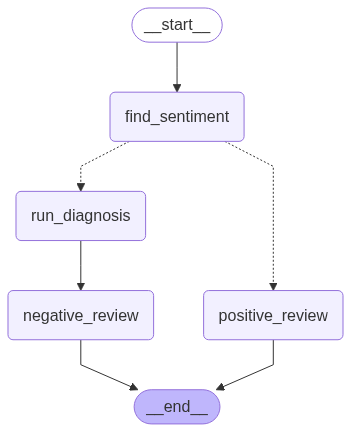

In [66]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_review', positive_review)
graph.add_node('negative_review', negative_review)
graph.add_node('run_diagnosis', run_diagnosis)

# Entry point
graph.add_edge(START, 'find_sentiment')

# Conditional edges (MAPPING ADDED ✅)
graph.add_conditional_edges('find_sentiment', check_condition)
  
# Continue workflow
graph.add_edge('run_diagnosis', 'negative_review')
graph.add_edge('positive_review', END)
graph.add_edge('negative_review', END)

# Compile graph
workflow = graph.compile()
workflow

In [67]:
initial_state = {
    'review' :'This product is too bag'
}
response = workflow.invoke(initial_state)
response

{'review': 'This product is too bag',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'UX', 'tone': 'disappointed', 'urgency': 'low'},
 'response': DiagnosisSchema(issue_type='UX', tone='disappointed', urgency='low')}